## Part 5.5: Logistic regression


Logistic regression allows to pose a classification problem as a regression problem, where the predicted label is the probability for a sample to belong to a certain class. Thus, in our case the output of the algorithm is the *gammaness*. We can then choose a threshold for the *gammaness* to assign gamma (+1) as the predicted label. The learning problem is to find the sigmoid function
$\sigma_{\mathbf{w}}(\mathbf{x}) =\frac{1}{1 + e^{-(\mathbf{w}^T \mathbf{x})}}$
that minimizes the loss:

$$
\mathcal{L}(\mathbf{y}, \sigma_{\mathbf{w}}(\mathbf{x})) + \lambda|\mathbf{w}\|^2
$$
where: 
$$
\mathcal{L}(\mathbf{y}, \sigma_{\mathbf{w}}(\mathbf{x})) = -\sum_{i=1}^{n} \left[ y_i \log(\sigma_{\mathbf{w}}(\mathbf{x}_i)) + (1 - y_i) \log(1 - \sigma_{\mathbf{w}}(\mathbf{x}_i)) \right]$$
and we use the Tikhonov regularization technique to prevent overfitting.

To find the best hyper-parameter $C=\frac{1}{\lambda}$ for model we choose the usual 0.5 threshold for the *gammaness* and perform a K-fold cross validation, where again we keep as best model the one that maximizes the partial AUC. 

In [98]:
from sklearn.linear_model import LogisticRegression
from time import time
auc_scorer = make_scorer(full_auc_scorer, greater_is_better=True, response_method='predict') 

# hyper-parameters 
param_grid = {'C': [0.001,0.005,0.01,0.05,0.1,0.5,1,5,10,50,100,500,1000]} # we use Tikhonov regularization: in the loss we add a term proportional to the norm squared of w (C=1/lambda)

# grid search with K-fold validation
K=5

fprs = []
tprs = []
aucs = []
partial_aucs = []
C = []
for c in param_grid['C']:
        auc_value=0
        partial_auc=0
        print(f"Training model with regularization constant c = {c}")
        C.append(c)
        for i in range(K):
            train_K, valid_K = split_train_test_set(train_set,K)
            X_train_K, Y_train_K = split_X_Y(train_K)
            X_valid_K, Y_valid_K = split_X_Y(valid_K)
            model= LogisticRegression(penalty='l2',C=c,solver='lbfgs',max_iter=300) # 'lbfgs' approximates up to the the second derivative of the loss function to optimize the coefficients, best for large datasets 
            model.fit(X_train_K,Y_train_K)
                    
            y_pred_proba = model.predict_proba(X_valid_K)[:, 1]  
            fpr, tpr, _ = roc_curve(Y_valid_K, y_pred_proba)
            fprs.append(fpr)
            tprs.append(tpr)
            auc_value_k = auc(fpr, tpr)
            # keep fpr less than 0.2 (if not able to find it, partial auc is set to zero)
            partial_fpr = fpr[fpr <= 0.2]
            if (len(partial_fpr) < 2 ):
                partial_auc=0
            else:
                partial_tpr = tpr[:len(partial_fpr)]
                partial_auc_k = auc(partial_fpr, partial_tpr)
            partial_auc += partial_auc_k/K
            auc_value += auc_value_k/K
        print('Partial AUC:', partial_auc)
        partial_aucs.append(partial_auc)
        print('AUC:', auc_value,'\n')
        aucs.append(auc_value)                

Training model with regularization constant c = 0.001
Partial AUC: 0.0425120340315054
AUC: 0.702387207800642 

Training model with regularization constant c = 0.005
Partial AUC: 0.04516235684407596
AUC: 0.7148977021989907 

Training model with regularization constant c = 0.01
Partial AUC: 0.0425061084166532
AUC: 0.7107484261768969 

Training model with regularization constant c = 0.05
Partial AUC: 0.0437424984322651
AUC: 0.7130639300127177 

Training model with regularization constant c = 0.1
Partial AUC: 0.04128276996918249
AUC: 0.7095460421143089 

Training model with regularization constant c = 0.5
Partial AUC: 0.043471062505950314
AUC: 0.7142156485955287 

Training model with regularization constant c = 1
Partial AUC: 0.04223086067248544
AUC: 0.7152326168526155 

Training model with regularization constant c = 5
Partial AUC: 0.04411271648935983
AUC: 0.715898674061023 

Training model with regularization constant c = 10
Partial AUC: 0.044438655499424794
AUC: 0.7184669253979885 

Tra

In [102]:
best_partial_auc = np.max(np.array(partial_aucs))
best_auc= np.max(np.array(aucs))
best_index = np.where(partial_aucs==best_partial_auc)[0]
print('Best model with regularization constant c=',C[best_index[0]])
print('Best partial AUC (validation set):', best_partial_auc)
print('AUC of best model (validation set):', best_auc,'\n')

best_model = LogisticRegression(penalty='l2', C= C[best_index[0]],solver='lbfgs',max_iter=300)
best_model.fit(X_train,Y_train) # retrain the best
y_pred_proba_test = model.predict_proba(X_test)[:, 1]  
fpr_test, tpr_test, _ = roc_curve(Y_test, y_pred_proba_test)
auc_test= auc(fpr_test,tpr_test)

partial_fpr_test = fpr_test[fpr_test <= 0.2]
if (len(partial_fpr_test)<2):
    partial_auc_test=0
else:
    partial_tpr_test = tpr_test[:len(partial_fpr_test)]
    partial_auc_test = auc(partial_fpr_test, partial_tpr_test)
print('Best partial AUC (test set):', partial_auc_test)
print('AUC of best model (test set):', auc_test)
Q_log = get_best_Q(fpr_test,tpr_test)
print('Q value of best model:',Q_log)

Best model with regularization constant c= 100
Best partial AUC (validation set): 0.04550807368804595
AUC of best model (validation set): 0.7184970947552114 

Best partial AUC (test set): 0.03941393798370449
AUC of best model (test set): 0.7137378154488802
Q value of best model: 1.1378295433065941


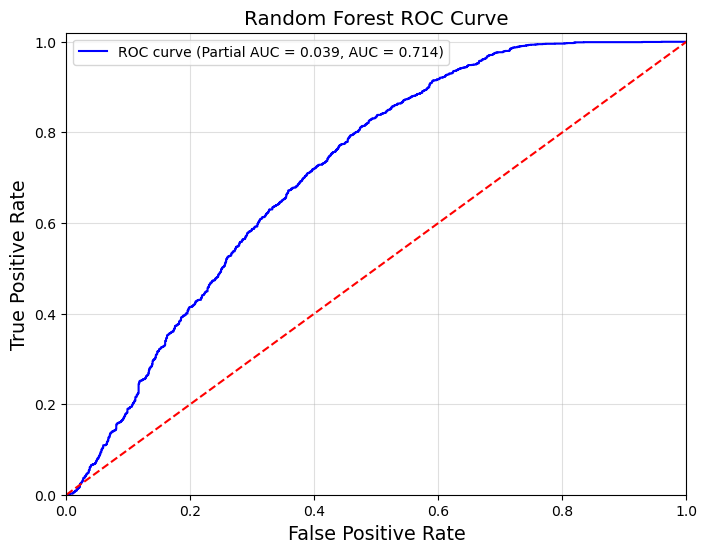

In [110]:
plt.figure(figsize=(10, 7))
plt.plot(fpr_test, tpr_test, color='blue', lw=1.5, label=f'ROC curve (Partial AUC = {partial_auc_test:.3f}, AUC = {auc_test:.3f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--') 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])
plt.xlabel('False Positive Rate',fontsize=13.8)
plt.ylabel('True Positive Rate',fontsize=13.8)
plt.title('Random Forest ROC Curve',fontsize=14.3)
plt.grid(alpha=0.4)
plt.legend(loc='best')
plt.show()